In [5]:
import pandas as pd
import numpy as np
import requests
import json
import csv
import re
import nltk
import umap
import pymorphy2
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
MEDUZA_URL = 'https://meduza.io/api/v3/'
NEWS_LIST_URL = 'search?chrono=news&locale=ru&page={}&per_page=24'

morph = pymorphy2.MorphAnalyzer()

In [9]:
title_col = []
pub_date_col = []
body_col = []

for i in tqdm(range(100)):
    response = requests.get(MEDUZA_URL + NEWS_LIST_URL.format(str(i)))
    news_list_json = json.loads(response.text)

    for todo in (news_list_json["documents"]):
        news = news_list_json["documents"][todo]
        if re.findall('^news', news["url"]):
            response = requests.get(MEDUZA_URL + news["url"])
            
            body = json.loads(response.text)['root']['content']['body']
            body = re.sub('<.+?>', '', body)
            body = re.sub('\\xa0|\\n', ' ', body)
            
            title_col.append(news['title'])
            pub_date_col.append(news['pub_date'])
            body_col.append(body)
            
news_df = pd.DataFrame({'title': title_col, 'pub_date': pub_date_col, 'body': body_col})

100%|██████████| 100/100 [06:35<00:00,  3.96s/it]


In [10]:
news_df.head()

,title,pub_date,body
0,В Третьяковской галерее на Крымском валу из-за...,2020-08-26,Обновлено. Представ...
1,В дом Валерия и Вероники Цепкало пришли с обыском,2020-08-26,В Минске в доме неза...
2,Убийца Джона Леннона получил отказ в досрочном...,2020-08-26,Комиссия по условно-...
3,"Суд взыскал с Навального 3,3 миллиона рублей с...",2020-08-26,Арбитражный суд Моск...
4,Сайт МГУ сообщил о зачислении на бюджет полной...,2020-08-26,"Анастасия Шувалова, ..."


In [11]:
news_df.shape[0]

1425

In [12]:
def normalixze_pymorphy(text):
    IMP_POS = ['ADJF', 'ADJS', 'NOUN', 'VERB', 'PRTF', 'PRTS', 'GRND']
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        if pv[0].tag.POS in IMP_POS and pv[0].normal_form != 'быть':
            words.append(pv[0].normal_form)
    return words

In [13]:
news_df['vocabular'] = [normalixze_pymorphy(w) for w in news_df.body]
tfCounter = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r'[А-Яа-яЁё]+\-[А-Яа-яЁё]+|[А-Яа-яЁё]+')
tfres = tfCounter.fit_transform([' '.join([w for w in v]) for v in news_df.vocabular])

In [14]:
news_df.head()

,title,pub_date,body,vocabular
0,В Третьяковской галерее на Крымском валу из-за...,2020-08-26,Обновлено. Представ...,"[обновить, представитель, галерея, сообщить, к..."
1,В дом Валерия и Вероники Цепкало пришли с обыском,2020-08-26,В Минске в доме неза...,"[минск, дом, незарегистрированный, кандидат, п..."
2,Убийца Джона Леннона получил отказ в досрочном...,2020-08-26,Комиссия по условно-...,"[комиссия, условно-досрочный, освобождение, шт..."
3,"Суд взыскал с Навального 3,3 миллиона рублей с...",2020-08-26,Арбитражный суд Моск...,"[арбитражный, суд, москва, взыскать, основател..."
4,Сайт МГУ сообщил о зачислении на бюджет полной...,2020-08-26,"Анастасия Шувалова, ...","[анастасий, шувалов, полный, тёзка, дочь, бывш..."


In [15]:
freqwords = []
for i in tqdm(range(news_df.shape[0])):

    tfs = [(k,tfres[i][0, tfCounter.vocabulary_.get(k)]) for k in news_df.vocabular.iloc[i] 
         if k in tfCounter.vocabulary_.keys()]
    fw = [w for w, f in sorted(tfs, key = lambda x: x[1], reverse = True)[:5]]
    freqwords.append(fw)
    
news['Freq Words TFIDF'] = freqwords

100%|██████████| 1425/1425 [00:17<00:00, 83.71it/s]


In [16]:
eblow_crit = []

for k in tqdm(range(1, 16)):
    eblow_crit.append(KMeans(n_clusters=k, random_state=None).fit(tfres).inertia_)

100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


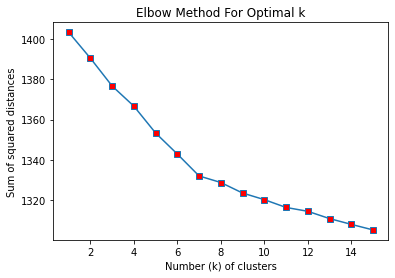

In [17]:
plt.plot(range(1, 16), eblow_crit, marker = 's', mfc = 'red')
plt.xlabel('Number (k) of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [18]:
km = KMeans(n_clusters=3, random_state=None).fit(tfres)
classes = km.labels_

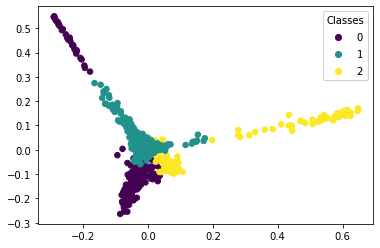

In [19]:
# Уменьшим размерность до 2D
pca = PCA(n_components=2, random_state=1)
reduced_features = pca.fit_transform(tfres.toarray())

fig, ax = plt.subplots()
scatter = ax.scatter(reduced_features[:,0], reduced_features[:,1], c=classes, s=30)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.show()

In [20]:
print(tfres[0])

  (0, 29552)	0.05153542510466464
  (0, 15433)	0.0544521991320449
  (0, 17510)	0.0544521991320449
  (0, 84799)	0.0544521991320449
  (0, 42771)	0.0544521991320449
  (0, 87188)	0.0544521991320449
  (0, 48272)	0.05675991880936679
  (0, 99824)	0.0544521991320449
  (0, 39719)	0.0544521991320449
  (0, 77657)	0.0544521991320449
  (0, 84793)	0.0544521991320449
  (0, 96431)	0.0544521991320449
  (0, 53673)	0.042188838218285014
  (0, 8125)	0.0544521991320449
  (0, 42773)	0.0544521991320449
  (0, 46594)	0.0544521991320449
  (0, 62801)	0.036576650702282984
  (0, 20221)	0.05153542510466464
  (0, 60278)	0.0544521991320449
  (0, 107470)	0.0544521991320449
  (0, 60893)	0.0544521991320449
  (0, 58535)	0.0544521991320449
  (0, 18278)	0.0544521991320449
  (0, 56505)	0.0544521991320449
  (0, 47693)	0.0544521991320449
  :	:
  (0, 104821)	0.2178087965281796
  (0, 56229)	0.019604813265776868
  (0, 30453)	0.01495185532229525
  (0, 72242)	0.034971434120546804
  (0, 84967)	0.1089043982640898
  (0, 47393)	0.021655